# MM: Dedicated for the plots in the thesis


In [1]:
# Add the parent path 
import os, sys
# Get the current working directory
current_working_directory = os.getcwd()

# Get the parent directory
parent_directory = os.path.dirname(current_working_directory)
# Add the parent directory to sys.path
sys.path.append(parent_directory)
sys.path.append(parent_directory + "/core")



In [70]:
# Some imports 
%load_ext autoreload
%autoreload 2
from pathlib import Path
import matplotlib as mpl
import pandas as pd
import logging
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import matplotlib.colors as mcolors

import corner
import lymph

import sys, os
from core.icd_definitions import desc_to_icd, icd_to_desc
from lyscripts.sample import sample_from_model
from core.em_sampling import em_sampler
from core.util_2 import (
    set_size,
    usz_colors,
    edge_colors,
    create_models,
    create_prev_vectors,
    convert_lnl_to_filename,
    plot_prevalences_icd,
    plot_prevalences_categories,
    reverse_dict,
    load_data,
    enhance_data,
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
# Set styling params and initialize the logger
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("../styles/mplstyle_rl.txt")

logger = logging.getLogger(__name__)
logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    )

In [ ]:
usz_blue = "#005ea8"
usz_blue_border = "#2387D5"
usz_green = "#00afa5"
usz_green_border = "#30DFD5"
usz_red = "#ae0060"
usz_red_border = "#FB4EAE"
usz_orange = "#f17900"
usz_orange_border = "#F8AB5C"
usz_gray = "#c5d5db"
usz_gray_border = "#DFDFDF"
usz_colors = [usz_blue, usz_green, usz_red, usz_orange, usz_gray]
edge_colors = [
    usz_blue_border,
    usz_green_border,
    usz_red_border,
    usz_orange_border,
    usz_gray_border,
]


## 1 Exploration of the subsite data

First, we set up directories and define properties for the lymph model we want to use.

In [30]:
# **Some Definitions**

# Set a name for the run.
NAME = "full_data_thesis"
PLOT_PATH = Path(f"figures/{NAME}/")
SAMPLE_PATH = Path(f"samples/{NAME}/")

# Create the directories
PLOT_PATH.mkdir(parents=True, exist_ok=True)
SAMPLE_PATH.mkdir(parents=True, exist_ok=True)

In [31]:
# Set the graph which we want to use
graph = {
        ("tumor", "primary"): ["I", "II", "III", "IV", "V", "VI"],
        ("lnl", "I"): [],
        ("lnl", "II"): [],
        ("lnl", "III"): [],
        ("lnl", "IV"): [],
        ("lnl", "V"): [],
        ("lnl", "VI"): [],

    }
lnls_full = graph["tumor", "primary"]

# Define wether we want to include t-stages or not.
ignore_t = True
if ignore_t:
    convert_t_stage = {0: "all", 1: "all", 2: "all", 3: "all", 4: "all"}
else:
    convert_t_stage = {0: "early", 1: "early", 2: "early", 3: "late", 4: "late"}

t_stages = list(set(convert_t_stage.values()))


### 1.1 Either load data or create a synthetic dataset

In [32]:
# Either use external data or use synth data
data_source = "REAL" # "SYNTH" | "REAL"

In [33]:
if data_source == "REAL":
    # Load the data.
    datasets_names = [
            "2022_CLB_multisite_enhanced.csv",
            "2022_CLB_oropharynx_enhanced.csv",
            "2022-ISB-multisite_enhanced.csv",
            "2023-usz-hypopharynx-larynx_enhanced.csv",
            "2022-USZ-oropharynx_enhanced.csv"
        ]
    dataset = load_data(datasets_names)
    dataset = enhance_data(dataset, convert_t_stage)
    dataset.head()

Succesfully loaded 1622 Patients


In [34]:
# .. or create a new synthetic dataset using a config.
if data_source == "SYNTH":
    from data.create_subsites_datasets import create_synth_data_by_config


    config = {
                "name": "synth_s1_s2_n0",
                "n": [200, 200, 200],
                "graph": {
                    ("tumor", "primary"): ["I", "II", "III"],
                    ("lnl", "I"): [],
                    ("lnl", "II"): ["I", "III"],
                    ("lnl", "III"): [],
                },
                "params": [
                    [0.3, 0.0, 0.3, 0.0, 0.0],
                    [0.0, 0.6, 0.6, 0.0, 0.0],
                    [0.01, 0.01, 0.01, 0.01, 0.01],
                ],
                "locations": ["S1", "S2", "S3"],
                "t_dist": {"early": 1, "late": 0},
            }
    dataset = create_synth_data_by_config(plot= False, save_dataset= False, **config)
    dataset = enhance_data(dataset, convert_t_stage)


### 1.2 Analyze the subsite data

In [35]:
dataset["tumor","1","location"].unique()

array(['hypopharynx', 'oral cavity', 'larynx', 'oropharynx'], dtype=object)

In [95]:
# Select which locations you want to analize
location_to_include = dataset["tumor","1","location"].unique()
location_to_include = ["oral cavity", "oropharynx", "hypopharynx", "larynx"]
# Icd codes in locations which you want to exlude (maybe those with low amount of patients).
icds_to_neglect = ["C00", "C08"]


In [96]:
# Now we create some dictionaries which are used later on, as maps from icd to dataset masks.

# Create a mask for the patients for each locations
loc_to_mask = {
    loc: dataset["tumor"]["1"]["location"] == loc for loc in location_to_include
}

# Location to icd dict
loc_to_icds_full = {
    loc: dataset[loc_to_mask[loc]]["tumor", "1", "majorsubsites"].unique()
    for loc in location_to_include
}
# Filtering out unwanted ICDs
loc_to_icds_model = {
    k: [icd for icd in v if icd not in icds_to_neglect]
    for k, v in loc_to_icds_full.items()
}

for k, v in loc_to_icds_model.items():
    print(f"In tumor location {k}: {v}")

# Dictionary for the relation icd - location
icd_to_loc_model = reverse_dict(loc_to_icds_model)

# For each icd, create a mask for the corresponding patients
icd_to_masks = {}
for icd in icd_to_loc_model.keys():
    icd_to_masks[icd] = dataset["tumor", "1", "majorsubsites"] == icd



In tumor location oral cavity: ['C02', 'C03', 'C04', 'C05', 'C06']
In tumor location oropharynx: ['C01', 'C09', 'C10']
In tumor location hypopharynx: ['C12', 'C13', 'C10']
In tumor location larynx: ['C32']


In [97]:
loc_to_icds_full

{'oral cavity': array(['C02', 'C03', 'C04', 'C05', 'C06', 'C08', 'C00'], dtype=object),
 'oropharynx': array(['C01', 'C09', 'C10'], dtype=object),
 'hypopharynx': array(['C12', 'C13', 'C10'], dtype=object),
 'larynx': array(['C32'], dtype=object)}

### 1.3 Create Plots



In [98]:
# Color mapping for locations
color_map = {loc: usz_colors[i] for i, loc in enumerate(location_to_include)}

In [99]:
# Counting the occurrence of each ICD code
icd_value_counts_sorted = dataset[
    np.logical_or.reduce(list(icd_to_masks.values()))
]["tumor", "1", "majorsubsites"].value_counts()

# Assigning colors to each ICD based on its location
colors = [
    color_map[icd_to_loc_model[icd]] for icd in icd_value_counts_sorted.keys()
]

# labels = [icd_to_loc_model[icd] for icd in icd_value_counts_sorted.keys()]

fig, ax = plt.subplots(1, figsize=set_size("full"))
icd_value_counts_sorted.plot(kind="barh", ax=ax, color=colors)

legend_elements = []
for loc in location_to_include:
    legend_elements.append(
        mpatches.Patch(color=color_map[loc], label=loc.capitalize())
    )
ax.set_xlabel("Number of Patients")
ax.set_ylabel("ICD's")
ax.legend(handles=[e for e in legend_elements])
fig.savefig(PLOT_PATH / "n_patients_icd.png")
fig.savefig(PLOT_PATH / "n_patients_icd.svg")
# plt.show()

logger.info(f"Created n_patients_icd figure in {PLOT_PATH}")

2024-01-15 14:41:10,460 - __main__ - INFO - Created n_patients_icd figure in figures/full_data_thesis


Prev Vector: [0.08569667077681874, 0.4956843403205919, 0.25524044389642414, 0.07398273736128237, 0.06226880394574599, 0.004315659679408138]
Prev Vector: [0.20050761421319796, 0.2918781725888325, 0.12436548223350254, 0.03807106598984772, 0.027918781725888325, 0.0]
Prev Vector: [0.08163265306122448, 0.7332361516034985, 0.31486880466472306, 0.09037900874635568, 0.07725947521865889, 0.0]
Prev Vector: [0.017241379310344827, 0.6206896551724138, 0.4885057471264368, 0.1839080459770115, 0.09770114942528736, 0.034482758620689655]
Prev Vector: [0.002717391304347826, 0.21195652173913043, 0.17391304347826086, 0.029891304347826088, 0.05434782608695652, 0.002717391304347826]


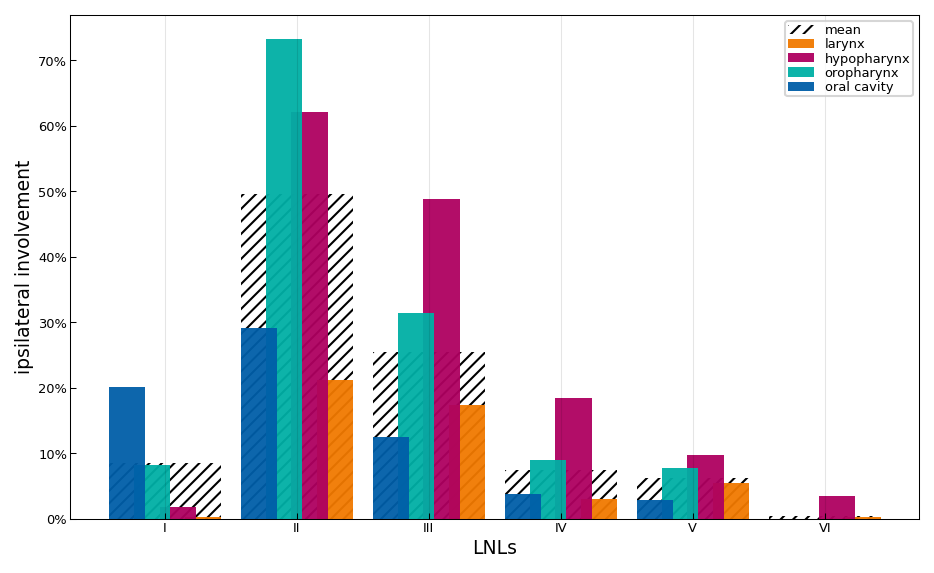

2024-01-15 14:41:59,765 - __main__ - INFO - Created prevalence figures in figures/full_data_thesis


In [102]:
# Create the plot comparing category for each LNL
   
# Here we do not consider early and late

prev_mean = create_prev_vectors(
    dataset,
    lnls_full,
    t_stages=t_stages,
    full_involvement=True,
    plot=False,
)

prev_loc = [
    create_prev_vectors(
        dataset[loc_to_mask[loc]],
        lnls_full,
        t_stages=t_stages,
        full_involvement=True,
    )
    for loc in location_to_include
]

plot_prevalences_categories(
    prev_loc,
    prev_mean,
    lnls_full,
    location_to_include,
    list(color_map.values()),
    edge_colors,
    save_name=PLOT_PATH
    / f"prev_categories_{convert_lnl_to_filename(lnls_full)}.png",
)

# prev_loc.append(prev_mean)
# prev_loc_df = pd.DataFrame(
#     np.round(np.array(prev_mean) * 100, 2),
#     index=[*location_to_include, loc.capitalize()],
#     columns=[str(s) for s in lnls_full],
# ).T
# prev_loc_df.to_csv(
#     PLOT_PATH / f"prev_categories_{convert_lnl_to_filename(lnls_full)}.csv"
# )
plt.show()
logger.info(f"Created prevalence figures in {PLOT_PATH}")



Prev Vector: [0.20050761421319796, 0.2918781725888325, 0.12436548223350254, 0.03807106598984772, 0.027918781725888325, 0.0]
Prev Vector: [0.13291139240506328, 0.34177215189873417, 0.16455696202531644, 0.06329113924050633, 0.05063291139240506, 0.0]
Prev Vector: [0.37777777777777777, 0.2, 0.0, 0.0, 0.0, 0.0]
Prev Vector: [0.2222222222222222, 0.23232323232323232, 0.1414141414141414, 0.0, 0.020202020202020204, 0.0]
Prev Vector: [0.1590909090909091, 0.36363636363636365, 0.11363636363636363, 0.09090909090909091, 0.022727272727272728, 0.0]
Prev Vector: [0.2391304347826087, 0.2608695652173913, 0.06521739130434782, 0.021739130434782608, 0.0, 0.0]


2024-01-15 17:21:24,627 - __main__ - INFO - Created prevalence figures in figures/full_data_thesis


Prev Vector: [0.08163265306122448, 0.7332361516034985, 0.31486880466472306, 0.09037900874635568, 0.07725947521865889, 0.0]
Prev Vector: [0.08571428571428572, 0.8571428571428571, 0.32571428571428573, 0.09142857142857143, 0.022857142857142857, 0.0]
Prev Vector: [0.07446808510638298, 0.723404255319149, 0.29521276595744683, 0.10372340425531915, 0.10638297872340426, 0.0]


2024-01-15 17:21:25,193 - __main__ - INFO - Created prevalence figures in figures/full_data_thesis


Prev Vector: [0.09558823529411764, 0.6029411764705882, 0.35294117647058826, 0.051470588235294115, 0.0661764705882353, 0.0]
Prev Vector: [0.017241379310344827, 0.6206896551724138, 0.4885057471264368, 0.1839080459770115, 0.09770114942528736, 0.034482758620689655]
Prev Vector: [0.011627906976744186, 0.6627906976744186, 0.5465116279069767, 0.1744186046511628, 0.12790697674418605, 0.023255813953488372]
Prev Vector: [0.022988505747126436, 0.5747126436781609, 0.4367816091954023, 0.19540229885057472, 0.06896551724137931, 0.04597701149425287]


2024-01-15 17:21:25,746 - __main__ - INFO - Created prevalence figures in figures/full_data_thesis


Prev Vector: [0.09558823529411764, 0.6029411764705882, 0.35294117647058826, 0.051470588235294115, 0.0661764705882353, 0.0]
Prev Vector: [0.002717391304347826, 0.21195652173913043, 0.17391304347826086, 0.029891304347826088, 0.05434782608695652, 0.002717391304347826]
Prev Vector: [0.002717391304347826, 0.21195652173913043, 0.17391304347826086, 0.029891304347826088, 0.05434782608695652, 0.002717391304347826]


2024-01-15 17:21:26,064 - __main__ - INFO - Created prevalence figures in figures/full_data_thesis


Prev Vector: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Prev Vector: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Prev Vector: [0.1896551724137931, 0.0, 0.08045977011494253, 0.005747126436781609, 0.05172413793103448, 0.0, 0.16091954022988506, 0.0, 0.017241379310344827, 0.0, 0.011494252873563218, 0.0, 0.011494252873563218, 0.0, 0.06896551724137931, 0.0, 0.005747126436781609, 0.0, 0.017241379310344827, 0.0, 0.005747126436781609, 0.0, 0.01724137

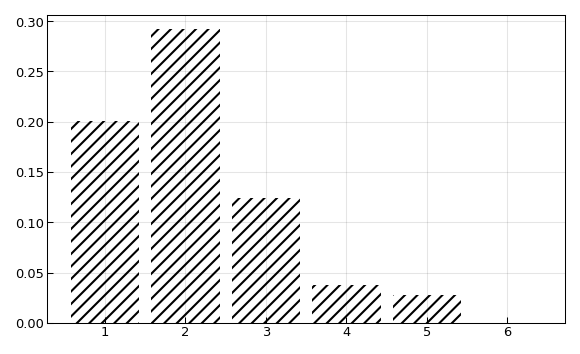

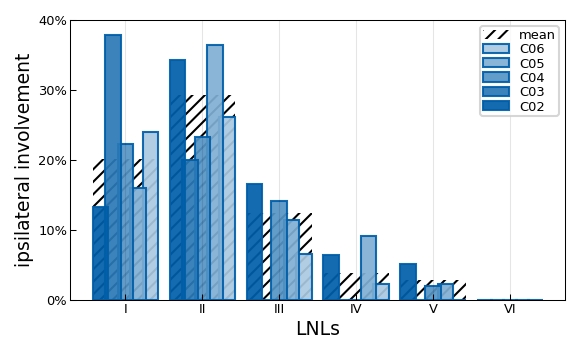

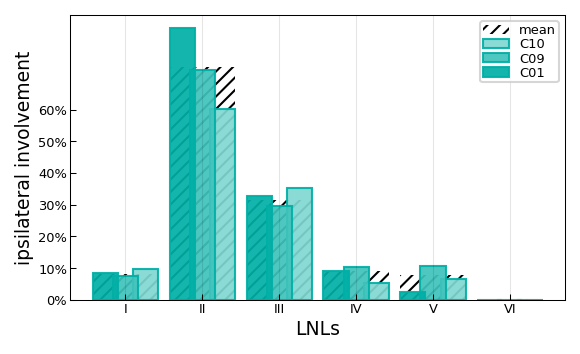

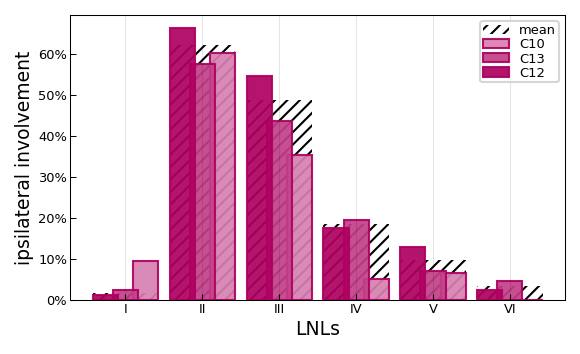

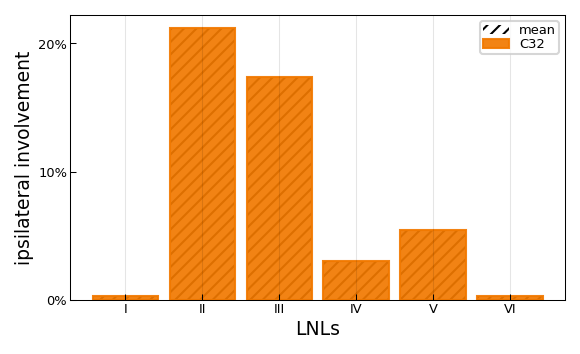

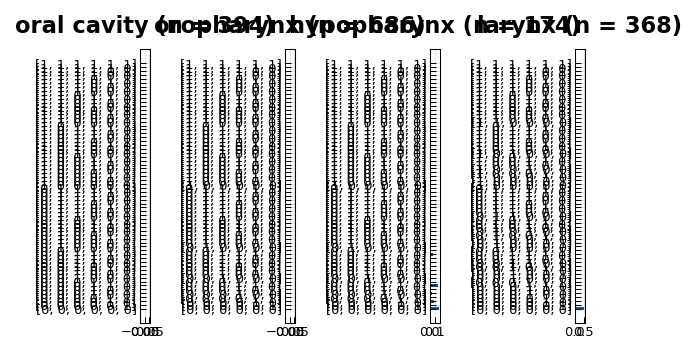

2024-01-15 17:21:35,366 - __main__ - INFO - Created prevalence figures in figures/full_data_thesis


In [106]:
# For every location, plot the prevalences of each corresponding icd code. 
if any(len(loc_to_icds_model[loc]) > 1 for loc in location_to_include):
    for loc in location_to_include:
    # Check if the location has more than one icd code.
   
        # Here we do not consider early and late
        prev_loc = create_prev_vectors(
            dataset[loc_to_mask[loc]],
            lnls_full,
            t_stages=t_stages,
            full_involvement=True,
            plot=False,
        )
        prev_loc_icds = [
            create_prev_vectors(
                dataset[icd_to_masks[icd]],
                lnls_full,
                t_stages=t_stages,
                full_involvement=True,
            )
            for icd in loc_to_icds_model[loc]
        ]

        plot_prevalences_icd(
            prev_loc_icds,
            prev_loc,
            lnls_full,
            loc_to_icds_model[loc],
            color_map[loc],
            save_name=PLOT_PATH
            / f"prev_{loc}_{convert_lnl_to_filename(lnls_full)}.png",
        )

        prev_loc_icds.append(prev_loc)
        prev_loc_df = pd.DataFrame(
            np.round(np.array(prev_loc_icds) * 100, 2),
            index=[*loc_to_icds_model[loc], loc.capitalize()],
            columns=[str(s) for s in lnls_full],
        ).T
        prev_loc_df.to_csv(
            PLOT_PATH / f"prev_{loc}_{convert_lnl_to_filename(lnls_full)}.csv"
        )
        logger.info(f"Created prevalence figures in {PLOT_PATH}")


# just plot prev in one single plot
# Check that the data is correct
fig, axs = plt.subplots(
    1,
    len(location_to_include),
    figsize=set_size(width="single"),
    tight_layout=True,
)
for i, loc in enumerate(location_to_include):
    create_prev_vectors(
        dataset[loc_to_mask[loc]],
        lnls_full,
        t_stages=t_stages,
        plot=True,
        title=loc,
        ax=axs[i],
    )
plt.show()
fig.savefig(PLOT_PATH / f"prev_{convert_lnl_to_filename(lnls_full)}.png")
logger.info(f"Created prevalence figures in {PLOT_PATH}")


### 1.4 Independent sampling for the locations (This is how it is done now)

In [20]:
def log_prob_fn(theta: np.ndarray | list) -> float:
    global MODEL
    for t in theta:
        if t < 0 or 1 < t:
            return -10000
    llh = MODEL.likelihood(given_param_args=theta, log=True)
    if np.isnan(llh):
        llh = -10000
    if np.isinf(llh):
        llh = -10000
    return llh

In [34]:
indep_nburnin = 250
indep_nstep = 500
params_sampling = {
    "walkers_per_dim": 20,
    "nsteps": 100,
    "thin_by": 1,
    "nburnin": 200,
}

# We need global variables, such that the likelihood functions work
global MODEL

models_loc = {}
for loc in location_to_include:
    model = create_models(1, graph, ignore_t_stage=ignore_t)
    model.load_patient_data(
        dataset[loc_to_mask[loc]], mapping=lambda x: convert_t_stage[x], side="ipsi"
    )
    models_loc[loc] = model
    # n_params = len(model.get_params())
    sample_name = Path(
        f"samples_ind_{loc}_{convert_lnl_to_filename(lnls_full)}_{ignore_t}"
    )
    output_dir = SAMPLE_PATH / sample_name
    if output_dir.with_suffix(".npy").exists():
        sampling_results = np.load(output_dir.with_suffix(".npy"))
        logger.warning(
            f"Found samples in {output_dir}. Skipping independent model sampling. "
        )
    else:
        logger.info(f"Start independent sampling for {loc}..")
        sampling_results = sample_from_model(
            model,
            params_sampling,
            SAMPLE_PATH,
            sample_name=sample_name,
            store_as_chain=True,
        )

2023-12-19 14:09:06,765 - __main__ - INFO - Start independent sampling for S1..
2023-12-19 14:09:06,767 - lyscripts.sample - INFO - Set up sampling for <class 'lymph.models.unilateral.Unilateral'> model with 3 parameters and 200 patients
2023-12-19 14:09:06,768 - lyscripts.sample - INFO - Prepared sampling params & backend at samples/synth_s1_s2_n0/samples_ind_S1_I_to_III_True.hdf5


Output()

2023-12-19 14:09:16,638 - root - INFO - Burn-in (8 cores) finished: Max. steps reached, acceptance rate was 34.67%


Output()

2023-12-19 14:09:22,014 - root - INFO - Sampling (8 cores) finished: Max. steps reached, acceptance rate was 43.75%
2023-12-19 14:09:22,140 - __main__ - INFO - Start independent sampling for S2..
2023-12-19 14:09:22,141 - lyscripts.sample - INFO - Set up sampling for <class 'lymph.models.unilateral.Unilateral'> model with 3 parameters and 200 patients
2023-12-19 14:09:22,143 - lyscripts.sample - INFO - Prepared sampling params & backend at samples/synth_s1_s2_n0/samples_ind_S2_I_to_III_True.hdf5


Output()

2023-12-19 14:09:31,138 - root - INFO - Burn-in (8 cores) finished: Max. steps reached, acceptance rate was 34.87%


Output()

2023-12-19 14:09:36,547 - root - INFO - Sampling (8 cores) finished: Max. steps reached, acceptance rate was 39.87%
2023-12-19 14:09:36,598 - __main__ - INFO - Start independent sampling for S3..
2023-12-19 14:09:36,599 - lyscripts.sample - INFO - Set up sampling for <class 'lymph.models.unilateral.Unilateral'> model with 3 parameters and 200 patients
2023-12-19 14:09:36,601 - lyscripts.sample - INFO - Prepared sampling params & backend at samples/synth_s1_s2_n0/samples_ind_S3_I_to_III_True.hdf5


Output()

2023-12-19 14:09:47,526 - root - INFO - Burn-in (8 cores) finished: Max. steps reached, acceptance rate was 29.27%


Output()

2023-12-19 14:09:53,877 - root - INFO - Sampling (8 cores) finished: Max. steps reached, acceptance rate was 46.05%


2023-12-19 14:09:54,538 - matplotlib.font_manager - WARNING - findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
2023-12-19 14:09:54,539 - matplotlib.font_manager - WARNING - findfont: Generic family 'cursive' not found because none of the following families were found: Lucida Calligraphy
2023-12-19 14:09:54,550 - matplotlib.font_manager - WARNING - findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans.
2023-12-19 14:09:54,551 - matplotlib.font_manager - WARNING - findfont: Generic family 'monospace' not found because none of the following families were found: Ubuntu Mono
2023-12-19 14:09:55,225 - __main__ - INFO - Created corner plot for samples for S1
2023-12-19 14:09:55,950 - __main__ - INFO - Created corner plot for samples for S2
2023-12-19 14:09:56,618 - __main__ - INFO - Created corner plot for samples for S3


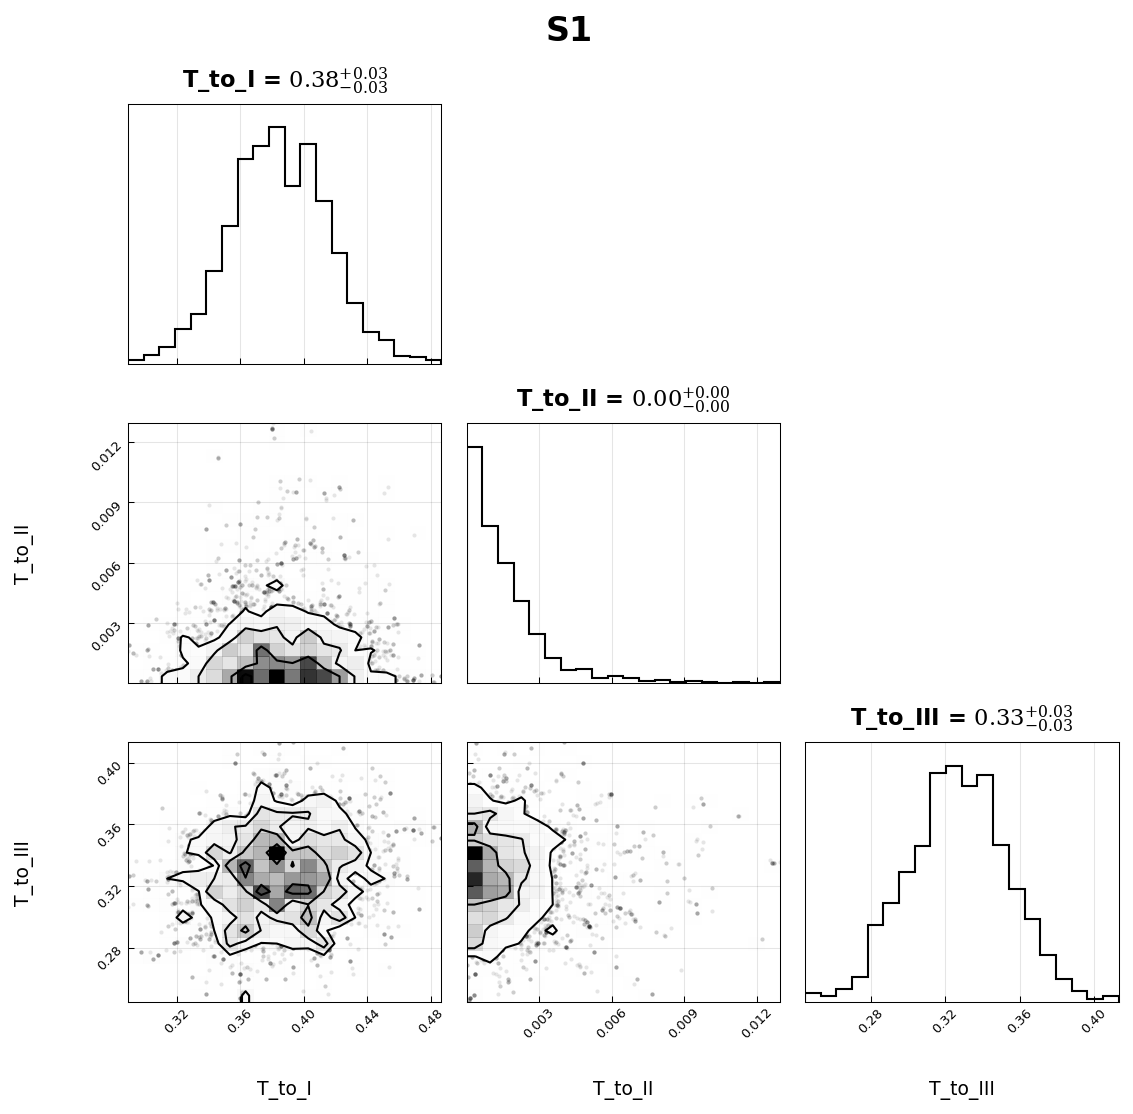

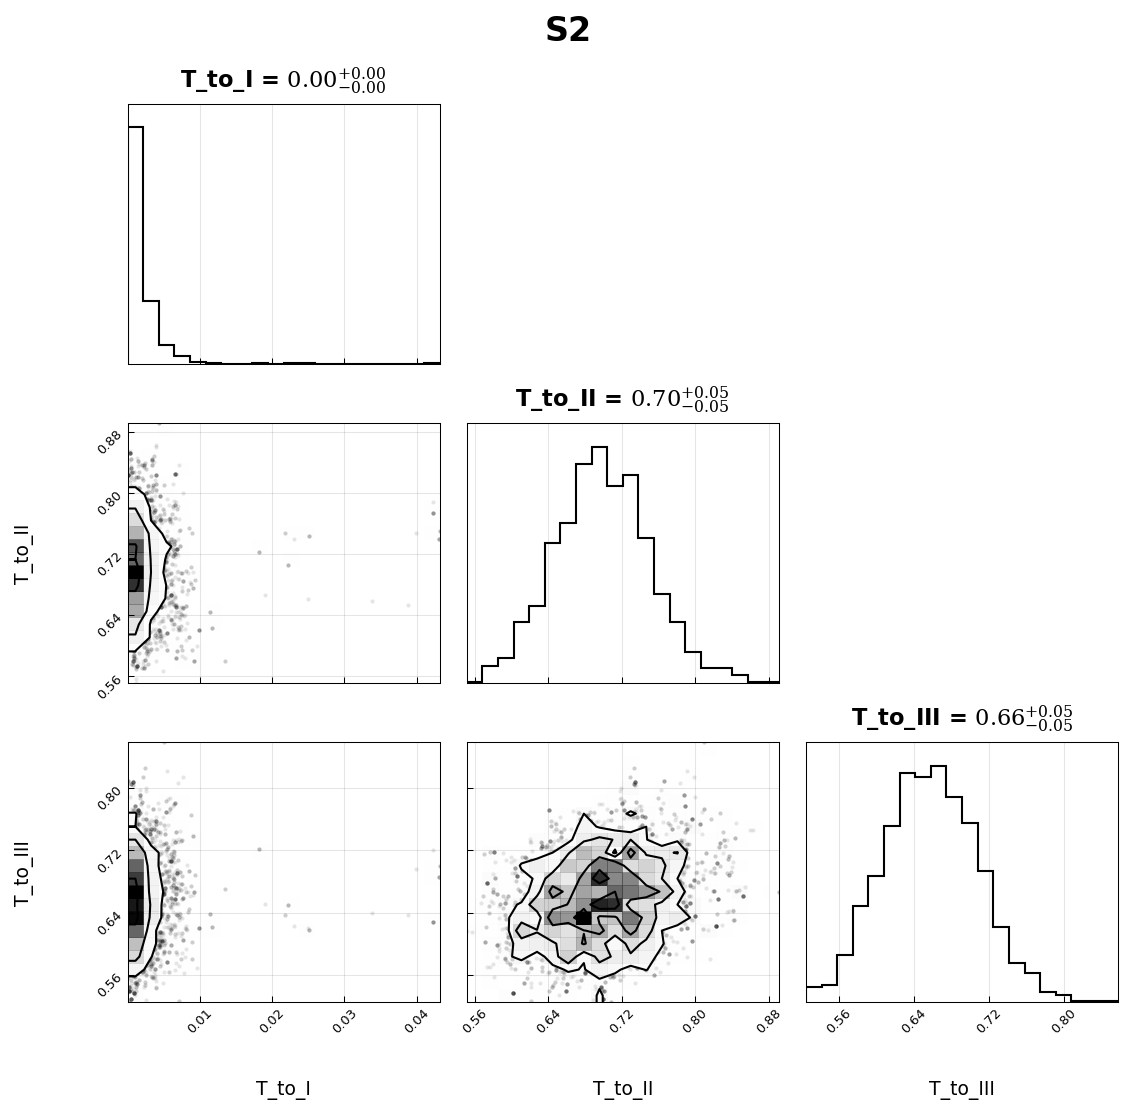

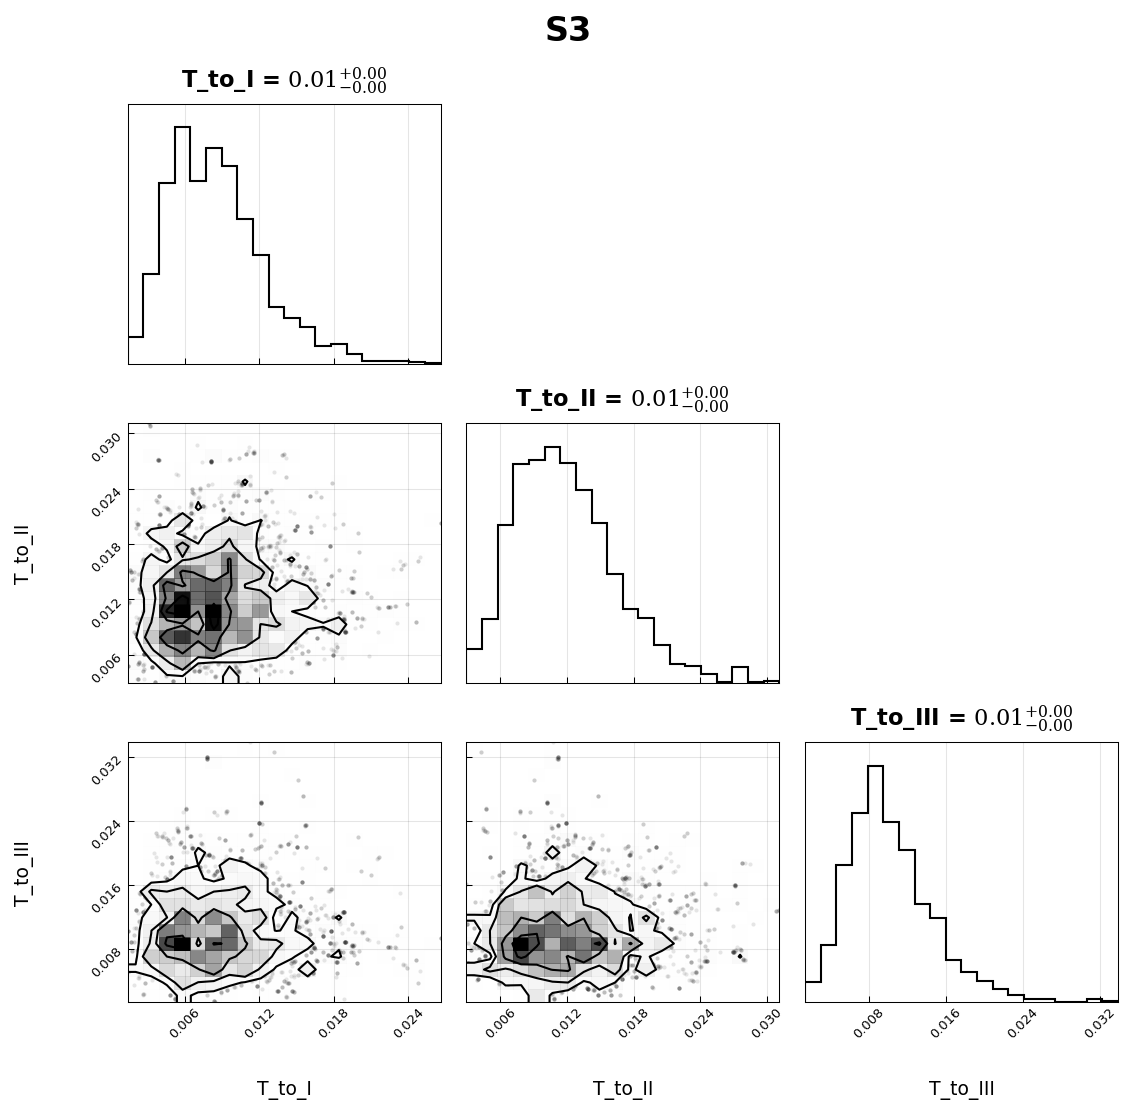

In [35]:
# For each location, generate the corner plot
for loc in location_to_include:
    # The sample name has to be the same as defined in sampling.
    sample_name = (
        f"samples_ind_{loc}_{convert_lnl_to_filename(lnls_full)}_{ignore_t}"
    )
    sample_dir = SAMPLE_PATH / sample_name
    samples = np.load(sample_dir.with_suffix(".npy"))

    # Ugly, may change to more robust function (e.g. get_lables)
    label_ts = [
        t.replace("primary", "T").replace("_spread", "")
        for t in models_loc[loc].get_params(as_dict=True).keys()
    ]
    fig = corner.corner(
        samples,
        labels=label_ts,
        show_titles=True,
    )
    fig.suptitle(f"{loc}", fontsize=16)
    fig.tight_layout()
    fig.savefig(PLOT_PATH / f"corner_ind_{loc}.png")
    # plt.show()
    logger.info(f"Created corner plot for samples for {loc}")

## The Mixture Model

Now we can move to the mixture model. This script can be used also only from this point on, without the previous chapter.

### 2.1 Create the models and loads each model with patient data from a ICD code.

In [81]:
# Again, define what data we want to use
# loc_to_icds_model ...


 # Create the model with the configs from before.
lymph_model_for_mixture = create_models(1, graph, ignore_t_stage=True)

In [82]:
n_clusters = 2
n_subpopulations = len(icd_to_masks)

# subpopulation data
subpopulation_data = [dataset[v] for v in icd_to_masks.values()]
subpopulation_labels = [l for l in icd_to_masks.keys()]

# The model which we want to use
lymph_model_for_mixture = create_models(1, graph, ignore_t_stage=True)

In [83]:
from core.mixture_model import LymphMixtureModel

# Create a new mixture model, given a lymph model which serves as the base model for each cluster
LMM = LymphMixtureModel(lymph_model_for_mixture, n_clusters=n_clusters, n_subpopulation=n_subpopulations, name = 'LMM_tutorial')
# Load the data, choose the t_stage mapping you want.
LMM.load_data(subpopulation_data, subpopulation_labels, mapping=lambda x: convert_t_stage[x])


2023-12-22 17:04:33,289 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/exploration/LMM_tutorial
2023-12-22 17:04:33,309 - core.mixture_model - INFO - Assigned S1 to supopulations with 200 patients
2023-12-22 17:04:33,315 - core.mixture_model - INFO - Assigned S2 to supopulations with 200 patients
2023-12-22 17:04:33,316 - core.mixture_model - INFO - Assigned S3 to supopulations with 200 patients


In [84]:
# Now we can check if the likelihood function works.

LMM.cluster_assignments = np.zeros(shape=(LMM.n_subpopulation * (LMM.n_clusters-1))) + 0.2
LMM.cluster_parameters = np.random.random(LMM.n_cluster_parameters)
LMM.mm_hmm_likelihood()

-1506.4208224975746

In [85]:
%load_ext autoreload
%autoreload 2
import importlib

import core.mixture_model
from core.costum_types import EMConfigType
importlib.reload(core.mixture_model)
from core.mixture_model import LymphMixtureModel

# Now that we are sure the likelihood works, we can fit the model to the data using the fit function
#
# from IPython.display import clear_output

# First we define configs for the EM algorithm.
em_config: EMConfigType = {
    "max_steps": 20,
    "method": "INVERTED",
    "verbose": True,
    "e_step": {
        "walkers_per_dim": 20,
        "nsteps": 30,
        "nburnin": 50,
        "sampler": "SIMPLE",
        "show_progress": True,
    },
    "m_step": {
        "minimize_method": "SLSQP",
        "imputation_function": lambda x: int(10 / (6) * x**1.1 + 1),
    },
    "convergence": {
        "criterion": "default",
        "default": {"lookback_period": 4, "threshold": 0.015},
    },
}

# .. and for the final MCMC sampling
mcmc_config = {
    "sampler": "SIMPLE",
    "sampling_params": {
        "walkers_per_dim": 20,
        "nsteps": 100,
        "nburnin": 400,
    },
}


given_cluster_assignments = [0.00565163,0.98224767, 0.00935772]
# given_cluster_assignments = None
history = LMM.fit(em_config=em_config, mcmc_config=mcmc_config, force_resampling = False, cluster_assignments = given_cluster_assignments)








2023-12-22 17:04:34,819 - core.mixture_model - WARNING - Skipping EM Algortihm, since cluster assignment is already given
2023-12-22 17:04:34,822 - core.mixture_model - INFO - MCMC sampling chain found in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/exploration/LMM_tutorial/samples/mcmc_sampling_chain_100_400.npy. Skipping Sampling.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


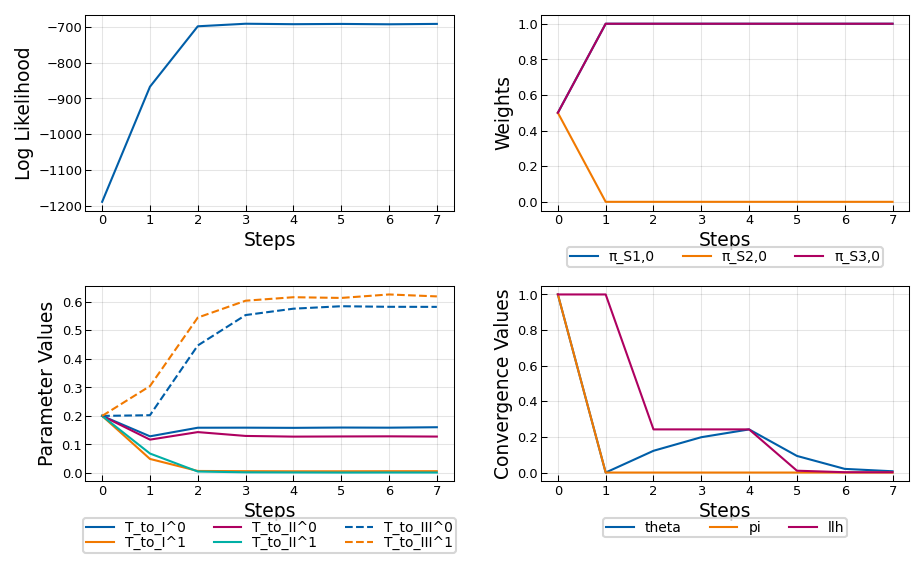

In [38]:
# Now we can check the progress of the EM algortihm by plotting the history data.
history.plot_history(LMM.subpopulation_labels, list(LMM.lymph_model.get_params(as_dict=True).keys()), LMM.n_clusters, None)

2023-12-22 16:13:51,150 - core.mixture_model - INFO - Saved matplotlib figure
/Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/core/mm_plotting.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


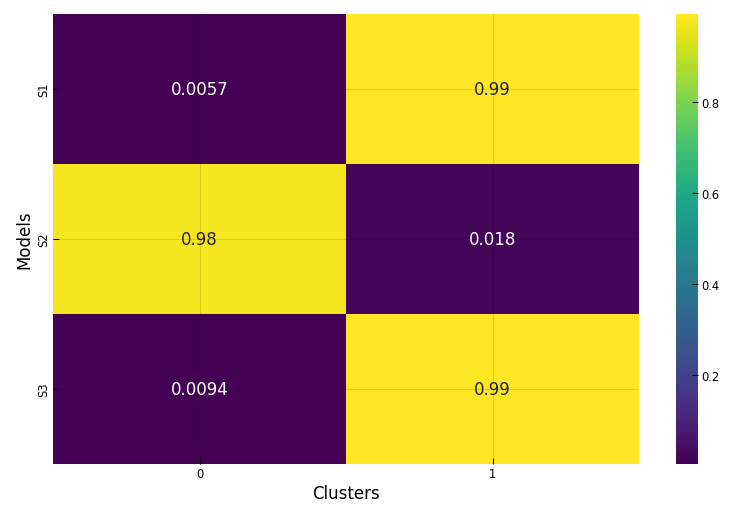

In [42]:
# Additionally, we can check the resulting cluster assignment matrix.
LMM.plot_cluster_assignment_matrix(labels=LMM.subpopulation_labels)

2023-12-22 16:13:52,744 - core.mixture_model - INFO - Saved matplotlib figure
/Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/core/mm_plotting.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
2023-12-22 16:13:53,497 - core.mixture_model - INFO - Saved matplotlib figure
/Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/core/mm_plotting.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


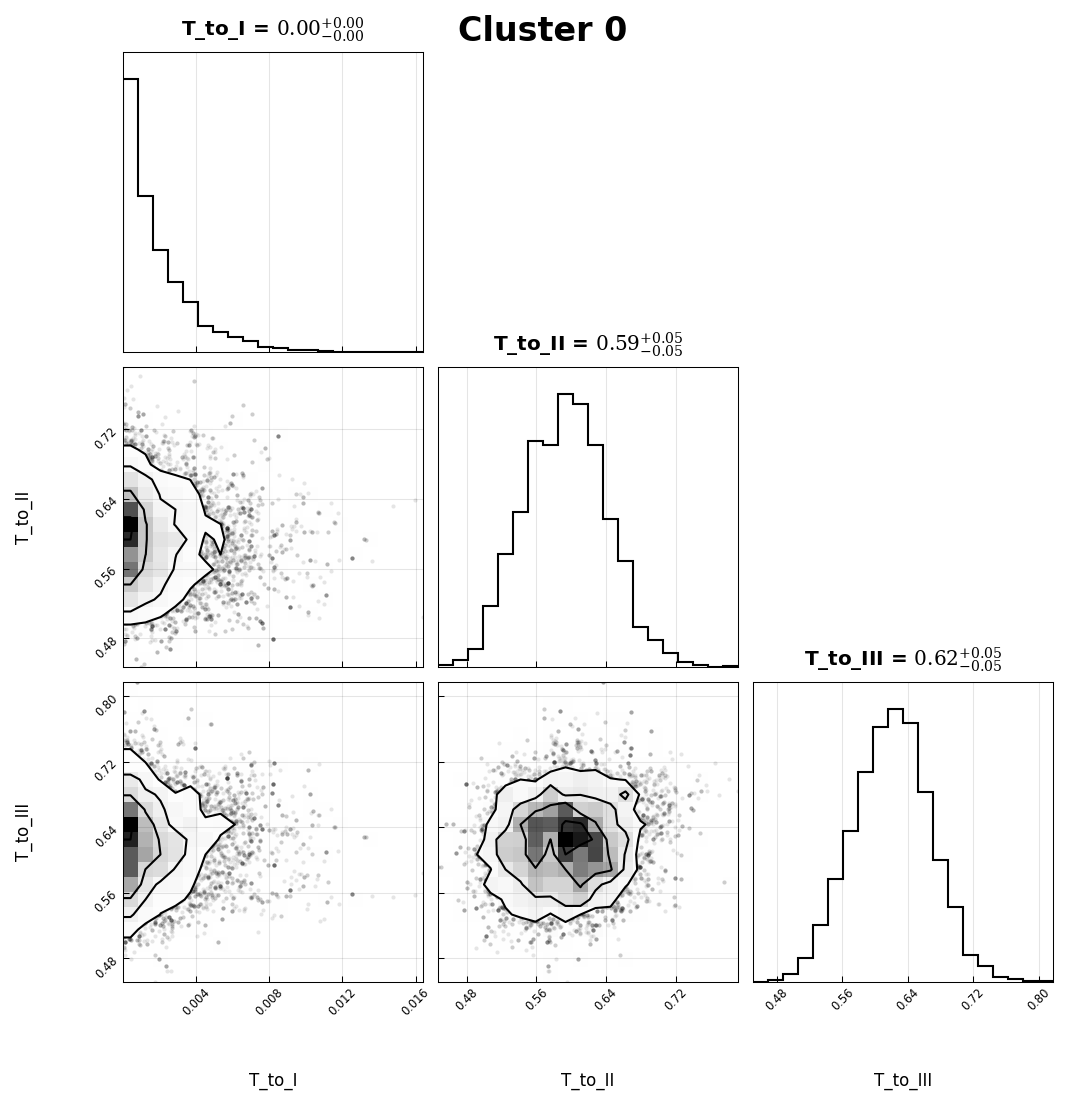

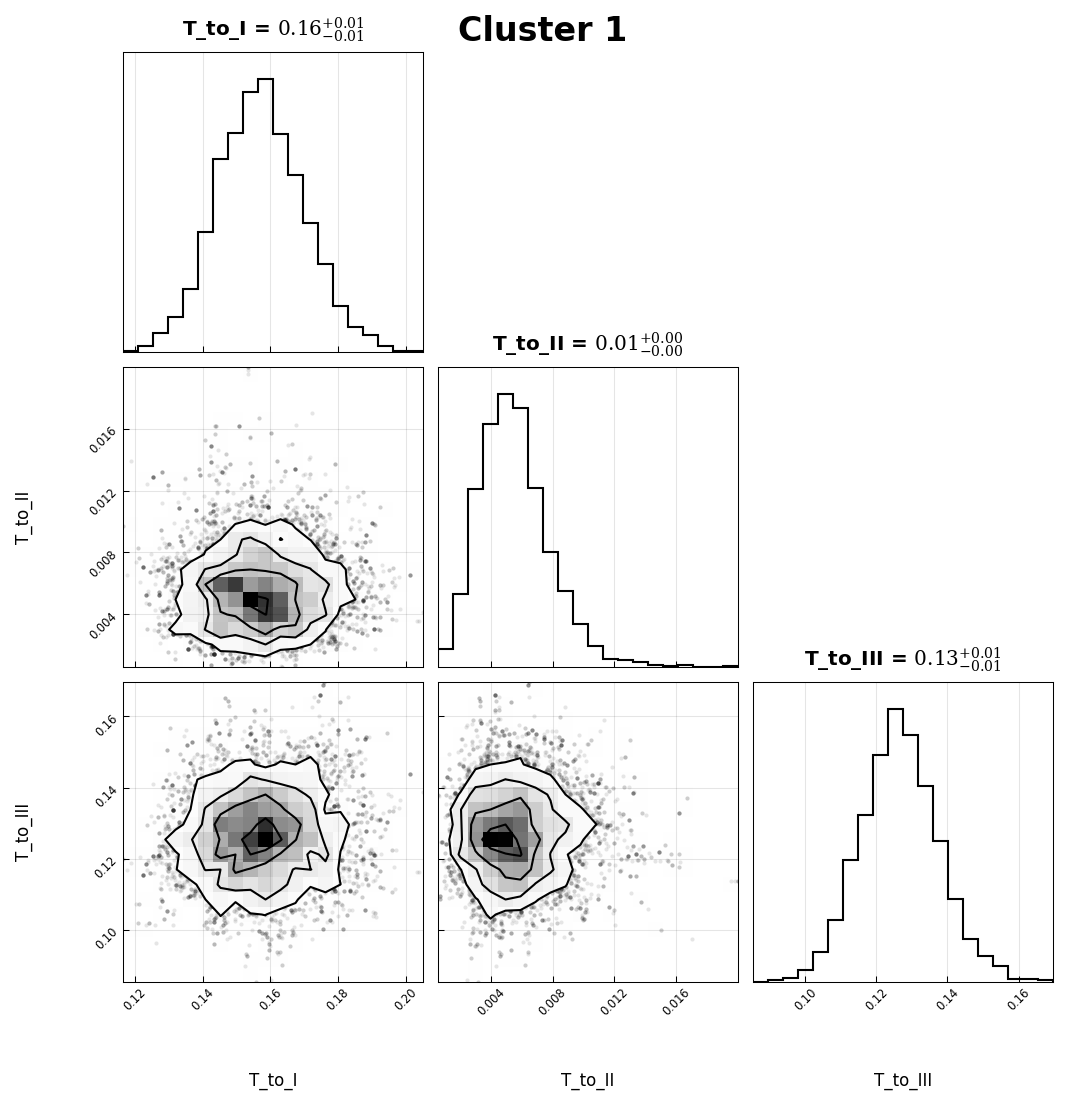

In [43]:
# .. and the new cluster parameters
LMM.plot_cluster_parameters()

## 2.3 Make predictions for single ICD code

In [86]:
 # create the patterns dataframe for all LNL's, (total risk for the lnl's)
from core.util_2 import create_states


states_all = create_states(lnls_full)

# 
label = "S1"
cluster_assignment_s1 = LMM.get_cluster_assignment_for_label(label)
print(f"The cluster assignment for {label} is: {cluster_assignment_s1}")
# data = dataset[loc_to_mask[label]]
# a, b = LMM.create_observed_predicted_df_for_cluster_assignment(cluster_assignment, states_all,data,"test")

The cluster assignment for S1 is: [0.00565163 0.99434837]


In [87]:
# Now we can use the model to predict prevalences for a given pattern
for_pattern = {"ipsi": {'I': True, 'II': False, 'III': False}}
LMM.predict_prevalence_for_cluster_assignment(cluster_assignment_s1, for_pattern, t_stage = 'all')

0.27887173634063156

In [91]:
# .. or calculate the risk given an diagnose
involvement = {"I": True}
given_diagnose = {"ipsi": {'I': True, 'II': False, 'III': False}}
given_diagnose_spsn = [0.76, 0.81]
LMM.predict_risk(cluster_assignment_s1, involvement, t_stage='all', given_diagnosis=given_diagnose, given_diagnosis_spsn=given_diagnose_spsn)

TypeError: Provided model is no valid `lymph` model.

In [92]:
type(LMM.lymph_model)

lymph.models.unilateral.Unilateral

In [54]:
from numpy import size


np.zeros(shape=(2,1))

array([[0.],
       [0.]])

In [2]:
import numpy as np
a = np.random.random(size=3)
b = np.random.random(size = 3)

In [3]:
a@b 


0.03479905333377842